In [1]:
# All Necessary Libraries

import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_groq import ChatGroq
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import List, Literal
from typing_extensions import TypedDict
from langchain_core.documents import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, StateGraph, START
from langchain_core.output_parsers import StrOutputParser

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Load the datasource
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs =[]
for url in urls:
    loader = WebBaseLoader(web_paths=[url])
    async for doc in loader.alazy_load():
        docs.append(doc)
print("The length of documents after loading",len(docs))

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.43it/s]

The length of documents after loading 3


In [3]:
# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
documents = text_splitter.split_documents(docs)
print("The length of documents after loading",len(documents))

The length of documents after loading 184


In [4]:
# Initate a embedding 
from langchain_huggingface import HuggingFaceEmbeddings
embeddings_model = HuggingFaceEmbeddings(model_name="ibm-granite/granite-embedding-125m-english")
# Initate the vector database with the embedding model and pass the documents
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings_model,
    persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
)
vector_store.add_documents(documents=documents)

d:\Generative AI\Langchain\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['c6f2cdc7-f1fe-4fbc-8712-d2db651079ce',
 'ee6aba6c-4c73-45a2-b6af-ce0b651d522c',
 'a7ac3da2-1fe8-4710-973d-e2521ff26c7b',
 '09a891cb-2554-4847-9ff5-38e22b7ac054',
 'b769029c-3a95-4218-8816-abffd041d041',
 'aeff8409-e668-4adf-9667-491245af07c9',
 'f59fdca0-4668-4e8d-a5b6-52f7e86b19e8',
 'b87d11ba-0c1b-4bdb-ad9a-32eb96004bab',
 '43ac2891-2d83-4933-8f33-d8809bf841d3',
 '3f8f98c7-30ab-41c2-a55b-a6573a65dd63',
 '3227effa-27f6-4def-b37d-3d0957cbd786',
 '344a2d97-f55d-4262-bd2b-c213dcb17284',
 'e3ad3bc9-756a-40b9-b5fa-8077cfd9e7c6',
 'c1783172-d168-4ab8-af04-10de57d7739b',
 '8c47a025-82a1-46b3-8701-92b9646acbbe',
 'b152aeaf-2250-45bb-8039-24512856a50c',
 '2198eb4a-d152-47f5-a028-442debd085cc',
 '916a85fe-4732-469b-880d-b7b84d579c16',
 'fdcb8a87-59e3-4010-a70c-fe94fd03d14a',
 '845e2322-6840-4863-b6dc-a3cfcaebe6e6',
 '8df6c978-64fc-4d71-8ce7-77d1e23d08e9',
 '9d0bb497-6f3e-4d53-8d7b-47c2b58ecd32',
 '2ed7993f-0f31-4ba5-ac46-2a3f9e939629',
 '1f41b939-c7d4-46b1-9e78-4cf89a1edb2d',
 'ac19cb30-f00a-

In [5]:
# Initate the retriever
retriever = vector_store.as_retriever(search_type = 'similarity',search_kwargs={'k':4})
retriever.invoke("What is agent")

[Document(id='289eea5c-53ca-41f9-b2c8-553e1e9935a8', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context 

In [6]:
# Working with tools
class Router(BaseModel):
    routing_to: Literal['websearch','doc_retriever'] = Field(description="Given a user question choose to route it to web search or a vectorstore.")
llm = ChatGroq(temperature=0, model_name="llama3-8b-8192")
structured_llm_router = llm.with_structured_output(Router)

system = """You are an expert at routing a user question to either a vectorstore or a web search engine.
The vectorstore contains documents on the following topics:
- AI agents (including types of agent memory)
- Prompt engineering
- Adversarial attacks

If the user question is about any of these topics, route it to 'doc_retriever'.
Otherwise, route it to 'websearch'.

Respond with one of: 'websearch' or 'doc_retriever' only.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

routing_to='websearch'
routing_to='doc_retriever'


In [7]:
class State(TypedDict):
    question: str
    response: str
    documents: List[str]

In [ ]:
def web_search_tool(state:State):
    api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)
    wikitool = WikipediaQueryRun(api_wrapper=api_wrapper)
    result = wikitool.invoke({'query': state['question']})
    documents = Document(page_content = result)
    return {'documents':documents,'question':state['question']}

In [ ]:
def retriever(state):
    documents = retriever.invoke(state['question'])
    return {'documents':documents,'question':state['question']}

In [16]:
def router(state):
    result = question_router.invoke({'question':state['question']})
    if result.routing_to == 'websearch':
        return 'websearch'
    else:
        return 'doc_retriever'


In [17]:
graph_builder = StateGraph(State)
graph_builder.add_node('websearch',web_search_tool)
graph_builder.add_node('doc_retriever',retriever)
graph_builder.add_conditional_edges(START,router,{"websearch": "websearch", 'doc_retriever': 'doc_retriever'})
graph_builder.add_edge( "doc_retriever", END)
graph_builder.add_edge( "websearch", END)
# Compile
app = graph_builder.compile()

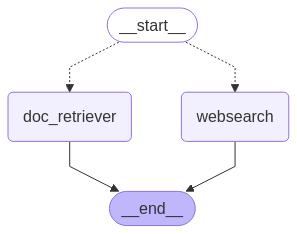

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

"Node 'websearch':"
'\n---\n'
Document(metadata={}, page_content='Page: Avengers: Endgame\nSummary: Avengers: Endgame is a 2019 American superhero film based on the Ma')
